In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import pandas as pd
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import save_model, load_model
import seaborn as sns
sns.set_theme()

path_data = 'data/'
path_train='Sentinel2LULC_354/'
path_test='Test 2/'
path_models='gdrive/MineriaIII/models/'
#path_models='drive/MyDrive/MineriaIII/models/'
path_pred='gdrive/MineriaIII/predictions/'
#path_pred='drive/MyDrive/MineriaIII/predictions/'
ext_sub = '.csv'

In [ ]:
label_groups = {1:1, 2:2, 3:3, 4:4,5:4, 6:5,7:5,8:5,9:5,10:5,11:5,12:5,13:5,14:5,15:5,16:5,17:5, 
                18:6,19:6,20:6, 21:7,22:7, 23:8, 24:9,25:9,26:9,27:9,28:9, 29:10}
subgroup = 6

In [ ]:
data = []
labels = []

for d in os.listdir(path_data + path_train):
    lab = int(re.search('\d{1,2}', d).group())
    if label_groups.get(lab) == subgroup:
        for f in os.listdir(path_data + path_train + d):
            try:
                img = imread(path_data + path_train + d + '/' + f)
                data.append(img)
                labels.append(lab)
            except:
                print("Cannot read file: " + d + '/' + f)

data = np.array(data)
labels = np.array(labels)

In [ ]:
test_data = []
test_labels = []

for f in os.listdir(path_data + path_test):
    lab = int(re.search('^(\d{1,2})_', f).group(1))
    if label_groups.get(lab) == subgroup:
        try:
            img = imread(path_data + path_test + f)
            test_data.append(img)
            test_labels.append(lab)
        except:
            print("Cannot read file: " + f)
            
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [ ]:
#data = data.astype('float32')/255.0
#test_data = test_data.astype('float32')/255.0

data = tf.keras.applications.vgg19.preprocess_input(data)
test_data = tf.keras.applications.vgg19.preprocess_input(test_data)

In [ ]:
nclasses = len(np.unique(labels))
img_shape = data.shape[1:4]
factor_labels = np.min(labels)

data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
      tf.keras.layers.experimental.preprocessing.RandomContrast(0.5)
  ])

In [ ]:
batch_size = 64
shuffle_buffer_size = 1000

train, val = train_test_split(np.arange(len(labels)), test_size=0.01, random_state=23, stratify=labels)
train_data = data[train]
train_labels = labels[train]
val_data = data[val]
val_labels = labels[val]

if nclasses > 2:
  train_labels_coded = tf.one_hot(train_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)
  val_labels_coded = tf.one_hot(val_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)
  test_labels_coded = tf.one_hot(test_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)
else:
  train_labels_coded = train_labels-factor_labels
  val_labels_coded = val_labels-factor_labels
  test_labels_coded = test_labels-factor_labels

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_data), tf.convert_to_tensor(train_labels_coded)))
#train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(val_data), tf.convert_to_tensor(val_labels_coded)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_data), tf.convert_to_tensor(test_labels_coded)))

train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)

In [ ]:
def create_model(binary=False):
  base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=img_shape, pooling='avg')
  base_model.trainable = False
  if binary:  
    model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  else:
    model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(nclasses)
    ])
  return model


def train_evaluate_model(model, name, binary=False, lr=0.0001):
  if binary:
    metric = 'binary_accuracy'
    metric_val = 'val_binary_accuracy' 
  else:
    metric = 'categorical_accuracy'
    metric_val = 'val_categorical_accuracy'

  earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor=metric_val,
    verbose=1,
    mode='max',
    patience=10,
    restore_best_weights=True
  )
  epochs = 50
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
  if binary:
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    metrics = [tf.keras.metrics.binary_accuracy]
  else:
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.categorical_accuracy]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  history = model.fit(train_batches,
                      epochs=epochs, 
                      validation_data=val_batches,
                      callbacks=[earlystopping])
  
  save_model(model, path_models + name + '.h5')

  evaluate_model(model, binary)


def train_evaluate_model2(model, name, binary=False, epochs=10, lr=0.0001):
  if binary:
    metric = 'binary_accuracy'
    metric_val = 'val_binary_accuracy' 
  else:
    metric = 'categorical_accuracy'
    metric_val = 'val_categorical_accuracy'

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
  if binary:
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    metrics = [tf.keras.metrics.binary_accuracy]
  else:
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.categorical_accuracy]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  history = model.fit(train_batches,
                      epochs=epochs, 
                      validation_data=val_batches)
  
  save_model(model, path_models + name + '.h5')

  evaluate_model(model, binary)


def evaluate_model(model, binary=False):
  test_loss, test_acc = model.evaluate(test_batches)
  print('Test loss: ' + str(test_loss) + ', test acc: ' + str(test_acc))
  
  if binary:
    val_preds = (model.predict(val_data) > 0.5).astype(int)
    test_preds = (model.predict(test_data) > 0.5).astype(int)
  else:
    val_preds = np.argmax(model.predict(val_data), axis=-1)
    test_preds = np.argmax(model.predict(test_data), axis=-1)
  val_matrix = tf.math.confusion_matrix(val_labels-factor_labels, val_preds)
  test_matrix = tf.math.confusion_matrix(test_labels-factor_labels, test_preds)

  fig, ax = plt.subplots(1, 2, figsize=(20,8))
  axlabs = [str(l) for l in np.unique(np.sort(train_labels))]

  im = sns.heatmap(ax=ax[0], data=val_matrix, annot=True, fmt="d")
  ax[0].set_xticks(np.arange(nclasses))
  ax[0].set_yticks(np.arange(nclasses))
  ax[0].set_xticklabels(axlabs)
  ax[0].set_yticklabels(axlabs)
  ax[0].set_title("Validation conf matrix")

  im = sns.heatmap(ax=ax[1], data=test_matrix, annot=True, fmt="d")
  ax[1].set_xticks(np.arange(nclasses))
  ax[1].set_yticks(np.arange(nclasses))
  ax[1].set_xticklabels(axlabs)
  ax[1].set_yticklabels(axlabs)
  ax[1].set_title("Test confusion matrix")

  plt.show()
  
  
def prep_finetuning(model, from_layer):
  model.layers[0].trainable = True
  for layer in model.layers[0].layers[:from_layer]:
    layer.trainable =  False

Epoch 1/50
15/15 [==============================] - 36s 2s/step - loss: 0.9440 - categorical_accuracy: 0.5414 - val_loss: 0.7005 - val_categorical_accuracy: 0.6542
Epoch 2/50
15/15 [==============================] - 12s 837ms/step - loss: 0.6678 - categorical_accuracy: 0.6911 - val_loss: 0.6262 - val_categorical_accuracy: 0.7477
Epoch 3/50
15/15 [==============================] - 13s 845ms/step - loss: 0.6472 - categorical_accuracy: 0.7309 - val_loss: 0.6684 - val_categorical_accuracy: 0.7103
Epoch 4/50
15/15 [==============================] - 13s 855ms/step - loss: 0.5177 - categorical_accuracy: 0.7812 - val_loss: 0.5895 - val_categorical_accuracy: 0.7850
Epoch 5/50
15/15 [==============================] - 13s 876ms/step - loss: 0.4328 - categorical_accuracy: 0.8094 - val_loss: 0.5388 - val_categorical_accuracy: 0.8037
Epoch 6/50
15/15 [==============================] - 13s 888ms/step - loss: 0.4009 - categorical_accuracy: 0.8168 - val_loss: 0.5364 - val_categorical_accuracy: 0.8224
E

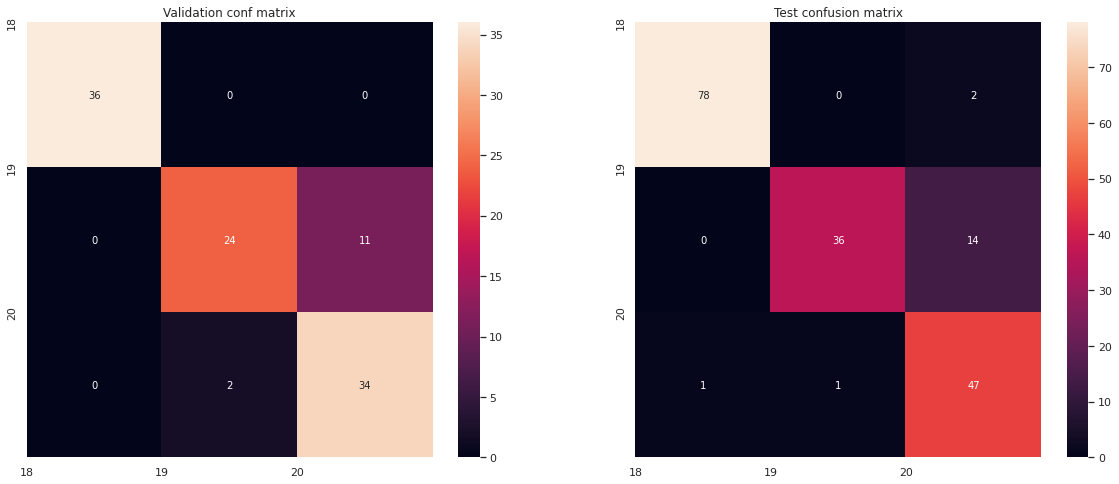

In [ ]:
model = create_model()
prep_finetuning(model, 0)
train_evaluate_model(model, 'wetland_512-128_ft', lr=0.0001)

Epoch 1/50
15/15 [==============================] - 14s 869ms/step - loss: 0.2215 - categorical_accuracy: 0.8953 - val_loss: 0.4321 - val_categorical_accuracy: 0.8785
Epoch 2/50
15/15 [==============================] - 13s 872ms/step - loss: 0.1772 - categorical_accuracy: 0.9225 - val_loss: 0.5451 - val_categorical_accuracy: 0.8598
Epoch 3/50
15/15 [==============================] - 13s 893ms/step - loss: 0.1556 - categorical_accuracy: 0.9298 - val_loss: 0.5611 - val_categorical_accuracy: 0.8692
Epoch 4/50
15/15 [==============================] - 13s 880ms/step - loss: 0.1419 - categorical_accuracy: 0.9435 - val_loss: 0.5553 - val_categorical_accuracy: 0.8598
Epoch 5/50
15/15 [==============================] - 13s 865ms/step - loss: 0.1391 - categorical_accuracy: 0.9424 - val_loss: 0.6316 - val_categorical_accuracy: 0.8598
Epoch 6/50
15/15 [==============================] - 13s 859ms/step - loss: 0.1207 - categorical_accuracy: 0.9435 - val_loss: 0.6102 - val_categorical_accuracy: 0.878

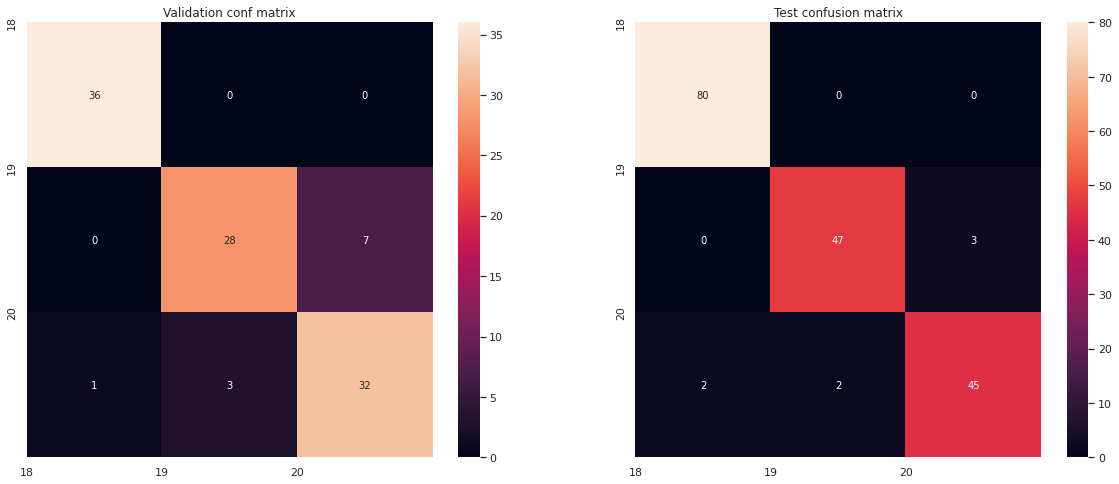

In [ ]:
train_evaluate_model(model, 'wetland_512-128_ft_v2', lr=0.00001)

Epoch 1/50
16/16 [==============================] - 35s 2s/step - loss: 0.1306 - categorical_accuracy: 0.9712 - val_loss: 0.4823 - val_categorical_accuracy: 0.9259
Epoch 2/50
16/16 [==============================] - 13s 796ms/step - loss: 0.1270 - categorical_accuracy: 0.9633 - val_loss: 0.4336 - val_categorical_accuracy: 0.9259
Epoch 3/50
16/16 [==============================] - 13s 799ms/step - loss: 0.1285 - categorical_accuracy: 0.9692 - val_loss: 0.4194 - val_categorical_accuracy: 0.9259
Epoch 4/50
16/16 [==============================] - 13s 808ms/step - loss: 0.1203 - categorical_accuracy: 0.9683 - val_loss: 0.4286 - val_categorical_accuracy: 0.9259
Epoch 5/50
16/16 [==============================] - 13s 807ms/step - loss: 0.1158 - categorical_accuracy: 0.9692 - val_loss: 0.4137 - val_categorical_accuracy: 0.9259
Epoch 6/50
16/16 [==============================] - 13s 815ms/step - loss: 0.1016 - categorical_accuracy: 0.9692 - val_loss: 0.4077 - val_categorical_accuracy: 0.9259
E

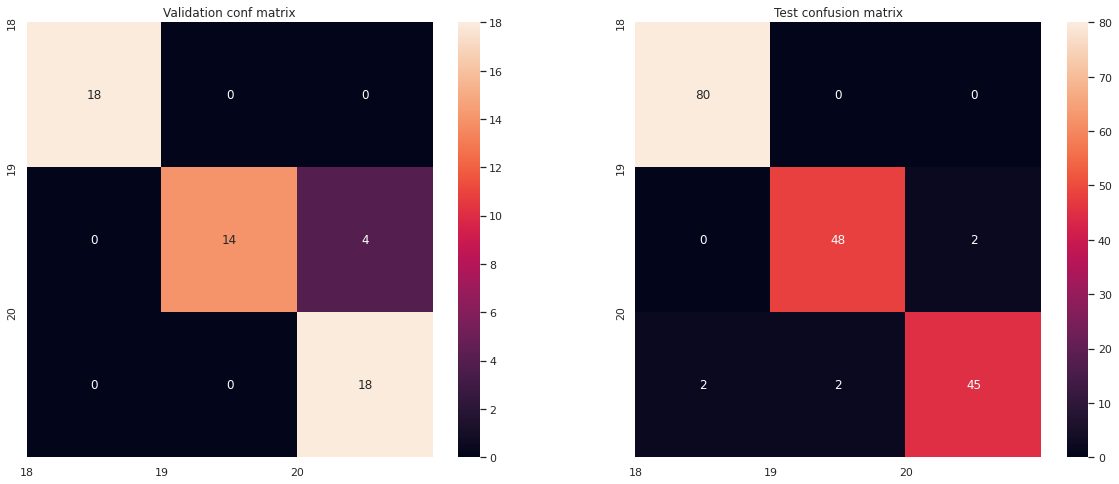

In [ ]:
modelv2 = load_model(path_models + 'wetland_512-128_ft_v2.h5')
train_evaluate_model(modelv2, 'wetland_512-128_ft_v3', lr=0.000001)

Epoch 1/10
17/17 [==============================] - 14s 756ms/step - loss: 0.1545 - categorical_accuracy: 0.9610 - val_loss: 0.2590 - val_categorical_accuracy: 0.8182
Epoch 2/10
17/17 [==============================] - 13s 760ms/step - loss: 0.1234 - categorical_accuracy: 0.9676 - val_loss: 0.2779 - val_categorical_accuracy: 0.8182
Epoch 3/10
17/17 [==============================] - 13s 772ms/step - loss: 0.0934 - categorical_accuracy: 0.9657 - val_loss: 0.3217 - val_categorical_accuracy: 0.8182
Epoch 4/10
17/17 [==============================] - 13s 772ms/step - loss: 0.0794 - categorical_accuracy: 0.9762 - val_loss: 0.5146 - val_categorical_accuracy: 0.7273
Epoch 5/10
17/17 [==============================] - 13s 781ms/step - loss: 0.0736 - categorical_accuracy: 0.9772 - val_loss: 0.5678 - val_categorical_accuracy: 0.6364
Epoch 6/10
17/17 [==============================] - 13s 786ms/step - loss: 0.0719 - categorical_accuracy: 0.9791 - val_loss: 0.3758 - val_categorical_accuracy: 0.818

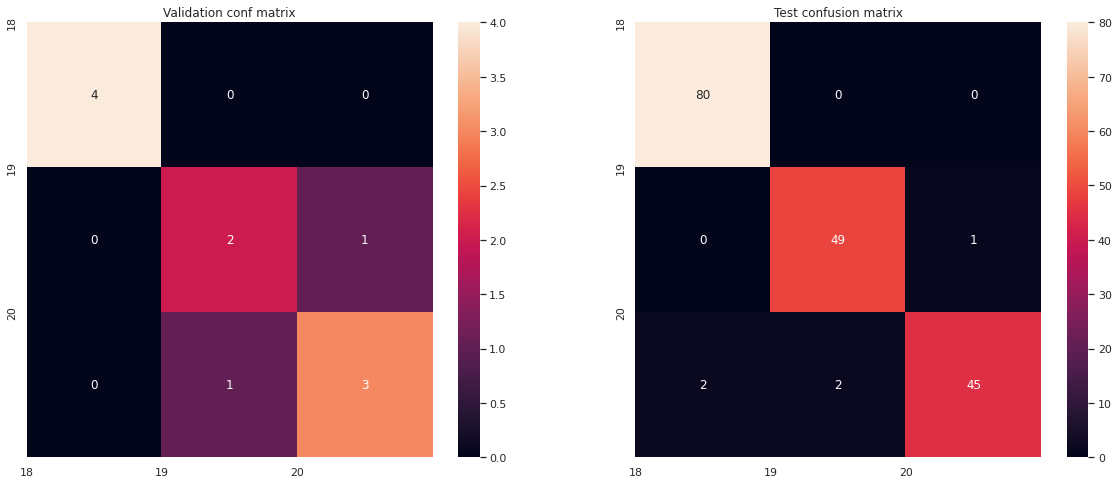

In [ ]:
modelv3 = load_model(path_models + 'wetland_512-128_ft_v3.h5')
train_evaluate_model2(modelv3, 'wetland_512-128_ft_v4', lr=0.00001)